# import all packages

In [1]:
import numpy as np
import pandas as pd
import os 
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pickle

# Training Code 

In [57]:
#Original
def load_and_process_tsv_files(directory):

    # Get a list of all TSV files in the directory
    tsv_files = glob.glob(os.path.join(directory, "*_cnv.tsv"))

    # Define the columns of interest
    columns_of_interest = ['chromosome',"readcount", 'gender', 'start']
    
    # Initialize an empty list to hold DataFrames
    df_list = []

    # Loop through each TSV file and read it
    for file in tsv_files:
        df = pd.read_csv(file, sep="\t")

        # Keep only the columns of interest if they exist in the current file
        df = df[[col for col in columns_of_interest if col in df.columns]]
        
        # Add a column for the file name (optional, helps track which file the data came from)
        df['sample'] = os.path.basename(file)
        
        # Append the cleaned DataFrame to the list
        df_list.append(df)

    # Combine all DataFrames into one
    combined_df = pd.concat(df_list, ignore_index=True)

    # Filter for rows where 'chromosome' is either 'chrX' or 'chrY'
    combined_df = combined_df[combined_df['chromosome'].isin(['chrX', 'chrY'])]

    # Remove '_l1_cnv.tsv' from the sample column
    combined_df['sample'] = combined_df['sample'].str.replace('_l1_cnv.tsv', '', regex=False)

    # Group by chromosome and sample and aggregate
    reduced_row = combined_df.groupby(['chromosome', 'gender', 'sample']).agg({
        'readcount': 'sum',  # Sum readcount values
    }).reset_index()

    # Pivot the DataFrame to get chromosomes as columns
    pivoted_df = reduced_row.pivot_table(index=['gender', 'sample'], columns='chromosome', values='readcount')

    # Reset the index to flatten the DataFrame
    pivoted_df.reset_index(inplace=True)

    # Filter for 'chrY' with specific start values for SRY gene
    sry_df = combined_df[
        (combined_df['chromosome'] == 'chrY') & 
        (combined_df['start'].isin([2000001]))
    ][['readcount', 'sample']]

    # SRY Gene Preprocessing
    sry_df.rename(columns={'readcount': 'sry_count'}, inplace=True)
    sry_df.reset_index(inplace=True, drop=True)

    # Merge the pivoted DataFrame with the SRY data
    final_df = pd.merge(pivoted_df, sry_df, on='sample', how='inner')

    # Encode gender as 0 for Male, 1 for Female
    final_df['gender'] = final_df['gender'].map({'Male': 1, 'Female': 0})
    final_df['chr_ratio'] = final_df['chrX'] / final_df['chrY'].replace(0, 0.8) 

    
    final_df['sample'] = final_df['sample'].str.replace('flexbarOut_barcode_', '', regex=False).str.replace('_trim_filtered_cnv.tsv', '', regex=False)
        
    # New Column  
    final_df["frac_X"] = final_df["chrX"]/(final_df["chrX"] + final_df["chrY"] )
    final_df["frac_Y"] = final_df["chrY"]/(final_df["chrX"] + final_df["chrY"] )

    return final_df

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def train_kmeans_model_and_plot(input_df: pd.DataFrame):
    """
    Train a K-means clustering model on the provided DataFrame and plot the results.

    Parameters:
        input_df (pd.DataFrame): The input DataFrame containing the data.

    Returns:
        KMeans: The trained KMeans model.
    """
    
    # Ensure the required columns are present in the DataFrame
    required_columns = ['chrX', 'chrY', 'sry_count', 'chr_ratio',"frac_X","frac_Y"]
    if not all(col in input_df.columns for col in required_columns):
        raise ValueError(f"The input DataFrame must contain the following columns: {required_columns}")

    # Select features for clustering
    selected_features = input_df[required_columns]

    # Standardize the feature values to have mean=0 and variance=1
    scaler = StandardScaler()
    # scaled_features = scaler.fit_transform(selected_features)
    scaled_features = scaler.fit_transform(selected_features)

    # Create KMeans model with 2 clusters for gender classification
    kmeans_model = KMeans(n_clusters=2, random_state=42)

    # Fit the model
    input_df['predicted_gender'] = kmeans_model.fit_predict(scaled_features)
    # input_df['predicted_gender'] = input_df['predicted_gender'].map({0: 1, 1: 0})   # if prediction got confused you can guid ethem 

    
    plt.figure(figsize=(10, 6))
    plt.scatter(input_df['chrX'], input_df['chrY'], 
                c=input_df['predicted_gender'], cmap='coolwarm', alpha=0.7)

    plt.title("K-means Clustering of Samples by Gender")
    plt.xlabel("chrX")
    plt.ylabel("chrY")
    
    # Label points with sample names
#     for i in range(len(input_df)):
#         plt.annotate(input_df['sample'][i], (input_df['chrX'][i], input_df['chrY'][i]), fontsize=8)

    plt.colorbar(label='Predicted Gender (1: Male, 0: Female)')
    plt.grid()
    plt.show()
    

    return input_df


import pickle

def save_combined_model(kmeans_model, scaler, combined_filename: str):
    """
    Save both the KMeans model and the StandardScaler to a single file.

    Parameters:
        kmeans_model (KMeans): The trained KMeans model.
        scaler (StandardScaler): The fitted StandardScaler.
        combined_filename (str): The filename to save both the model and the scaler.
    """

    # Create a dictionary to store both the model and scaler
    combined_model = {
        'model': kmeans_model,
        'scaler': scaler
    }

    # Save the dictionary to a single file
    with open(combined_filename, 'wb') as combined_file:
        pickle.dump(combined_model, combined_file)
    
    print(f"Combined model and scaler saved to {combined_filename}")


In [12]:
# # Filter for 'chrY' with specific start values for SRY gene
# sry_df = combined_df[
#     (combined_df['chromosome'] == 'chrY') & 
#     (combined_df['start'].isin([2000001]))
# ][['readcount', 'sample']]
# Filter for 'chrY' with specific start values for SRY gene

## Remove outlier

In [23]:
def remove_extreme_values(df, columns, lower_percentile=1, upper_percentile=99):
    """
    Removes extreme values from specified columns based on percentile thresholds.
    Parameters:
    - df: DataFrame to process.
    - columns: List of column names to process (e.g., ['chrX', 'chrY']).
    - lower_percentile: Lower bound percentile for filtering (default is 1).
    - upper_percentile: Upper bound percentile for filtering (default is 99).
    Returns:
    - DataFrame with extreme values removed in the specified columns.
    """
    df_clean = df.copy()
    for col in columns:
        lower_bound = df_clean[col].quantile(lower_percentile / 100)
        upper_bound = df_clean[col].quantile(upper_percentile / 100)
        
        # Filter values within the bounds
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

    # Reset the index after filtering
    df_clean = df_clean.reset_index(drop=True)
    return df_clean

# Data to be processd 

In [58]:
# directory path

dir1 = 'Test_Data_SRTOW/'
dir2 = 'Training_Data_MKTLY/'
dir3 = 'TAQ_Comparision/'  
dir4 = '8A_series_cnv_files/'  
dir5 = '7A/'                   
# dir6 = 'Micro_Y/'  the plot is scattred 

# dir11 = '/home/gaurav/Assignment/2/batch4353_bar21/'         # Nanopore 
# dir12 = '/home/gaurav/Assignment/2/batch4353_bar22/'         # Nanopore


healthy_samples_df4 =  ["8A681","8A682","8A689","8A690","8A691","8A692","8A693",
     "8A694","8A695","8A696","8A737","8A738","8A767","8A768"]

In [59]:
# loading all in one df 

df_1 = load_and_process_tsv_files(dir1)
df_2 = load_and_process_tsv_files(dir2)
df_3 = load_and_process_tsv_files(dir3)
df_4 = load_and_process_tsv_files(dir4)
df_5 = load_and_process_tsv_files(dir5)



# df_2_3 = pd.concat([df_2,df_3],ignore_index=True)
# Combined the data
# thermo_1 = pd.concat([df_2,df_5],ignore_index=True)
# thermo_2 = pd.concat([df_6,df_7],ignore_index=True)
# thermo_3 = pd.concat([thermo_1,thermo_2],ignore_index=True)
# nanopore = pd.concat([df_3,df_4],ignore_index=True)

#  Preprocessing on all Df

In [80]:
df_1_filtered = remove_extreme_values(df_1, columns=['chrX', 'chrY'],lower_percentile=0., upper_percentile=99.6)
df_2_filtered = remove_extreme_values(df_2, columns=['chrX', 'chrY'],lower_percentile=0., upper_percentile=99.6)
df_3_filtered = remove_extreme_values(df_3, columns=['chrX', 'chrY'],lower_percentile=6., upper_percentile=100)
df_4_filtered = remove_extreme_values(df_4, columns=['chrX', 'chrY'],lower_percentile=0., upper_percentile=99.)
df_5_filtered = remove_extreme_values(df_5, columns=['chrX', 'chrY'],lower_percentile=0, upper_percentile=100.)


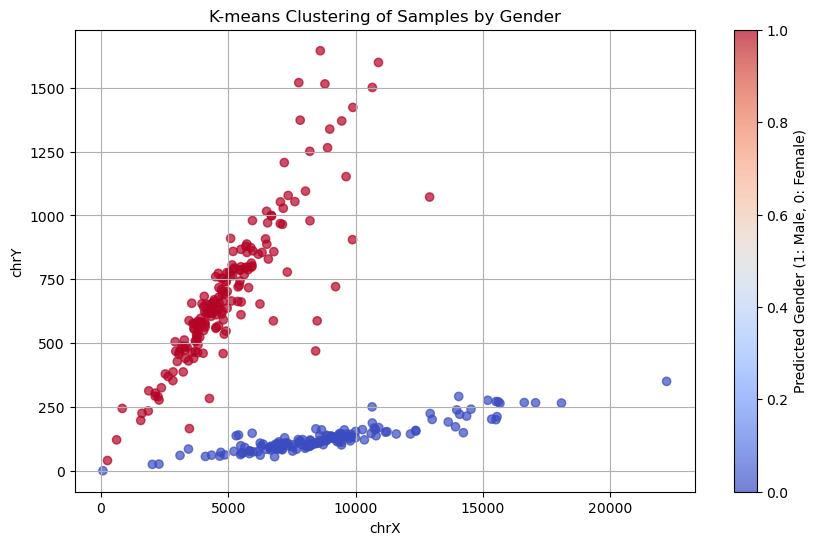

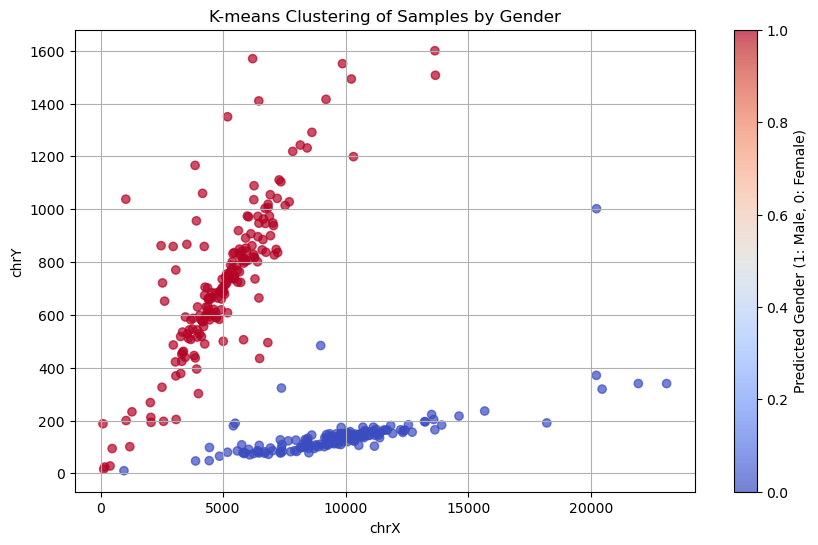

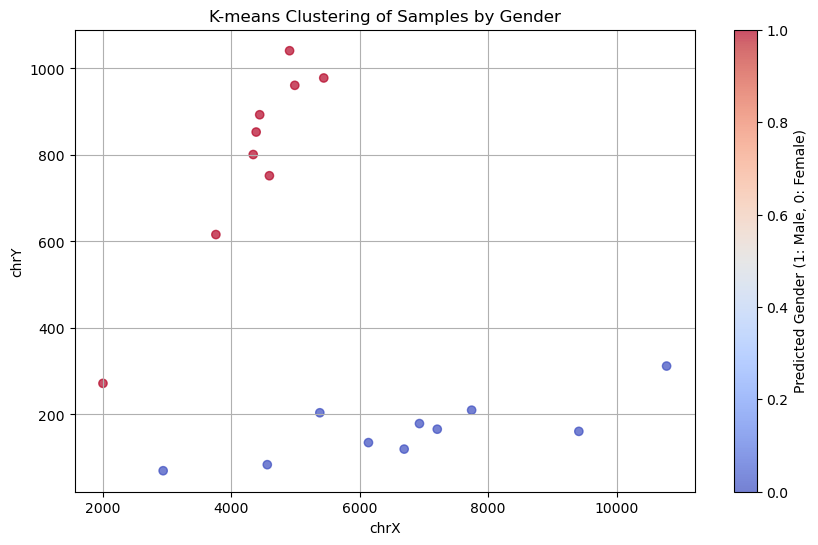

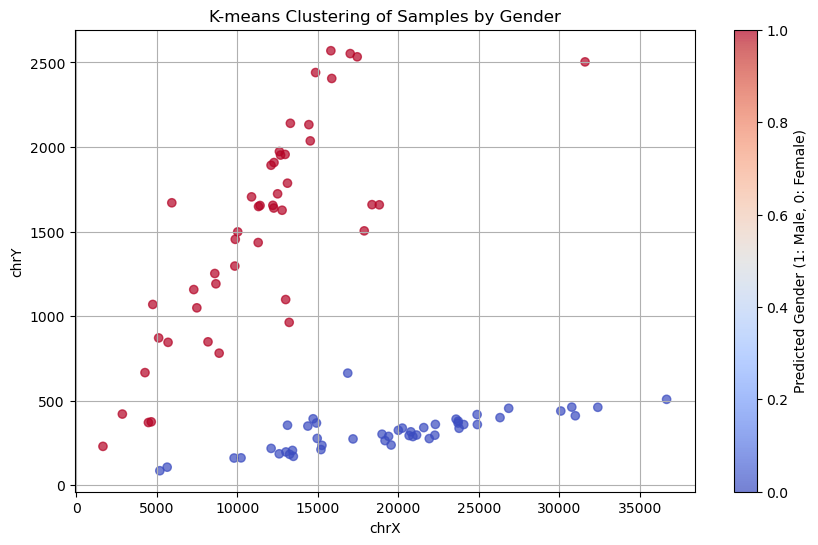

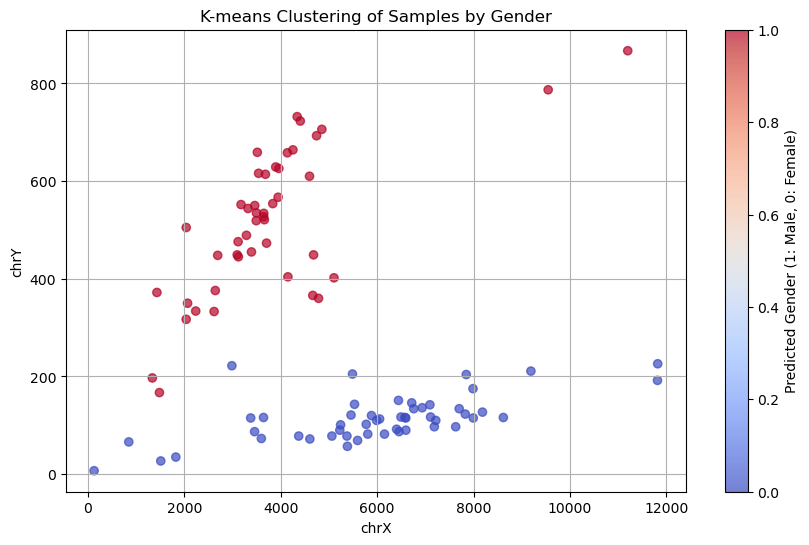

In [82]:
df_1_trained = train_kmeans_model_and_plot(df_1_filtered)
df_2_trained = train_kmeans_model_and_plot(df_2_filtered)
df_3_trained = train_kmeans_model_and_plot(df_3_filtered)
df_4_trained = train_kmeans_model_and_plot(df_4_filtered)
df_5_trained = train_kmeans_model_and_plot(df_5_filtered)


In [83]:
df_1_trained[df_1_trained["gender"] != df_1_trained["predicted_gender"]]

,gender,sample,chrX,chrY,sry_count,chr_ratio,frac_X,frac_Y,predicted_gender
152,1,102152SB-9,3438.0,85.0,3.0,40.447059,0.975873,0.024127,0
293,1,1180931,78.0,0.0,0.0,97.500000,1.000000,0.000000,0


In [84]:
df_2_trained[df_2_trained["gender"] != df_2_trained["predicted_gender"]]

,gender,sample,chrX,chrY,sry_count,chr_ratio,frac_X,frac_Y,predicted_gender
66,0,1167082_TH,5003.0,500.0,2.0,10.006000,0.909140,0.090860,1
68,0,11671610_TH,6485.0,435.0,1.0,14.908046,0.937139,0.062861,1
70,0,1167167_TH,5831.0,506.0,0.0,11.523715,0.920151,0.079849,1
322,1,LA0360B3_OG,7375.0,323.0,4.0,22.832817,0.958041,0.041959,0
323,1,LA0360B3_RT,20221.0,1002.0,12.0,20.180639,0.952787,0.047213,0


In [85]:
df_3_trained[df_3_trained["gender"] != df_3_trained["predicted_gender"]]

,gender,sample,chrX,chrY,sry_count,chr_ratio,frac_X,frac_Y,predicted_gender


In [86]:
df_4_trained[df_4_trained["gender"] != df_4_trained["predicted_gender"]]

,gender,sample,chrX,chrY,sry_count,chr_ratio,frac_X,frac_Y,predicted_gender
50,1,8A684,13119.0,355.0,4.0,36.95493,0.973653,0.026347,0


In [87]:
df_5_trained[df_5_trained["gender"] != df_5_trained["predicted_gender"]]

,gender,sample,chrX,chrY,sry_count,chr_ratio,frac_X,frac_Y,predicted_gender
34,1,7A578,5531.0,143.0,2.0,38.678322,0.974797,0.025203,0
35,1,7A579,6051.0,113.0,1.0,53.548673,0.981668,0.018332,0
41,1,7A587,3643.0,116.0,0.0,31.405172,0.969141,0.030859,0
42,1,7A588,3458.0,87.0,1.0,39.747126,0.975458,0.024542,0
43,1,7A589,5242.0,101.0,1.0,51.900990,0.981097,0.018903,0
44,1,7A590,3377.0,115.0,2.0,29.365217,0.967068,0.032932,0
46,1,7A592,3598.0,73.0,0.0,49.287671,0.980114,0.019886,0
47,1,7A593,7216.0,110.0,1.0,65.600000,0.984985,0.015015,0
51,1,7A600,6934.0,136.0,1.0,50.985294,0.980764,0.019236,0
53,1,7A604,5488.0,205.0,3.0,26.770732,0.963991,0.036009,0


### Merged all df in one for doing supervised learning 

In [88]:
# merged all the df in one 
thermo_df = pd.concat( [df_1_trained,
                        df_2_trained,
                        df_3_trained,
                        df_4_trained,
                        df_5_trained ],ignore_index=True)
del thermo_df["chr_ratio"]
del thermo_df["gender"]
thermo_df.rename(columns={"predicted_gender":"actual_gender"},inplace=True)  # male :1  & female : 0

# Supervised Learnig Model 

## Trying every model

In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load your DataFrame (replace with your actual file or DataFrame)
# thermo_df = pd.read_csv("your_file.csv")  # Uncomment if loading from a CSV file

# Define features and target
features = ['chrX', 'chrY', 'sry_count', 'frac_X', 'frac_Y']
target = 'actual_gender'

# Separate features, target, and sample column
X = thermo_df[features]
y = thermo_df[target]
sample_col = thermo_df['sample']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store models and their names
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', random_state=42, probability=True),  # SVM with RBF kernel
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train and evaluate each model
results = []
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test_scaled)
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results.append((name, accuracy))

    # Optionally print predictions alongside samples for debugging
    print(f"\n{name} Predictions:")
    predictions = pd.DataFrame({'sample': sample_col.loc[X_test.index], 'actual_gender': y_test, 'predicted_gender': y_pred})
    print(predictions)

# Display the accuracy results
print("\nModel Accuracies:")
for name, accuracy in results:
    print(f"{name}: {accuracy:.2f}")



Random Forest Predictions:
         sample  actual_gender  predicted_gender
394   116665SB5              0                 0
66      1169992              0                 0
495     1153271              1                 1
67     11709503              0                 0
855       7A652              1                 1
..          ...            ...               ...
81   1172889-WC              0                 0
558  1167048_TH              1                 1
351   1157445VD              0                 0
543  116271LM-5              1                 1
383    11665814              0                 0

[174 rows x 3 columns]

Logistic Regression Predictions:
         sample  actual_gender  predicted_gender
394   116665SB5              0                 0
66      1169992              0                 0
495     1153271              1                 1
67     11709503              0                 0
855       7A652              1                 1
..          ...            ...  

## make a model ON SVM algorithm and save it

In [90]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import joblib  # For saving the model and scaler

# Load your DataFrame (replace with your actual file or DataFrame)
# thermo_df = pd.read_csv("your_file.csv")  # Uncomment if loading from a CSV file

# Define features and target
features = ['chrX', 'chrY', 'sry_count', 'frac_X', 'frac_Y']
target = 'actual_gender'

# Separate features, target, and sample column
X = thermo_df[features]
y = thermo_df[target]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scaling the entire dataset

# Train the SVM model on the entire dataset
svm_model = SVC(kernel='rbf', random_state=42, probability=True)
svm_model.fit(X_scaled, y)

# Save the model and scaler in a dictionary
model_dict = {
    "svm_model": svm_model,
    "scaler": scaler
}

# Optionally save the model and scaler to disk using joblib
joblib.dump(model_dict, 'svm_model_thermo_v2')

print("Model and scaler have been trained and saved successfully.")


Model and scaler have been trained and saved successfully.


# import a model and Predict on new df

In [91]:
import joblib
import pandas as pd
import os

def load_and_process_single_tsv(tsv_file) -> pd.DataFrame:
    """
    Load and process a single TSV file.

    Parameters:
    tsv_file (str): The path to the single TSV file.

    Returns:
    pd.DataFrame: A DataFrame containing the processed data.
    """
    # Define the columns of interest
    columns_of_interest = ['chromosome', 'readcount', 'start']

    try:
        # Assume `tsv_file` is already a DataFrame (replace with `pd.read_csv()` if needed)
        dtf = tsv_file

        # Keep only the columns of interest if they exist in the file
        dtf = dtf[[col for col in columns_of_interest if col in dtf.columns]]

        # Filter for rows where 'chromosome' is either 'chrX' or 'chrY'
        dtf = dtf[dtf['chromosome'].isin(['chrX', 'chrY'])]

        # Safely assign the 'sample' column
        dtf.loc[:, 'sample'] = "Sample"

        # Group by chromosome and sample and aggregate
        reduced_row = dtf.groupby(['chromosome', 'sample']).agg({
            'readcount': 'sum',  # Sum readcount values
        }).reset_index()

        # Pivot the DataFrame to get chromosomes as columns
        pivoted_df = reduced_row.pivot_table(index=['sample'], columns='chromosome', values='readcount')
        pivoted_df.reset_index(inplace=True)

        # Filter for 'chrY' with specific start values for the SRY gene
        sry_df = dtf[(dtf['chromosome'] == 'chrY') & (dtf['start'].isin([2000001]))][['readcount', 'sample']]
        sry_df.rename(columns={'readcount': 'sry_count'}, inplace=True)
        sry_df.reset_index(drop=True, inplace=True)

        # Merge the pivoted DataFrame with the SRY data
        final_df = pd.merge(pivoted_df, sry_df, on='sample', how='inner')

        # Add fractional columns
        final_df["frac_X"] = final_df["chrX"] / (final_df["chrX"] + final_df["chrY"])
        final_df["frac_Y"] = final_df["chrY"] / (final_df["chrX"] + final_df["chrY"])

        return final_df

    except Exception as e:
        print(f"Error processing file: {e}")
        return None

def predict_gender(input_df: pd.DataFrame, combined_model_path: str) -> str:
    try:
        input_df = load_and_process_single_tsv(input_df)

        # Load model and scaler
        loaded_data = joblib.load(combined_model_path)
        loaded_model = loaded_data['svm_model']
        loaded_scaler = loaded_data['scaler']

        # Ensure required columns
        required_columns = ['chrX', 'chrY', 'sry_count', 'frac_X', 'frac_Y']
        if not all(col in input_df.columns for col in required_columns):
            raise ValueError(f"Missing required columns: {required_columns}")

        # Standardize features
        scaled_features = loaded_scaler.transform(input_df[required_columns])

        # Predict gender
        predictions = loaded_model.predict(scaled_features)
        input_df['predicted_gender'] = predictions

        # Check prediction results
        gender = input_df['predicted_gender'].astype(int)
        male = gender[gender == 1]
        female = gender[gender == 0]

        if not male.empty:
            return "Male"
        if not female.empty:
            return "Female"

        return "Unknown"

    except Exception as e:
        print(f"Error in prediction: {e}")
        return "Error"

# if __name__ == "__main__":
#     test_df = pd.read_csv(sys.argv[1], sep="\t")
#     print(predict_gender(test_df,"svm_model_thermo_v2"))

test_df = pd.read_csv('/home/gaurav/Data/PGTA/Thermo/Test_Data_SRTOW/11542113C_l1_cnv.tsv', sep="\t")
predict_gender(test_df,"svm_model_thermo_v2")

'Male'

# Raw Code (Optional)

In [ ]:
# Fit the model
input_df['predicted_gender'] = kmeans_model.fit_predict(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(input_df['chrX'], input_df['chrY'], 
            c=input_df['predicted_gender'], cmap='coolwarm', alpha=0.7)

plt.title("K-means Clustering of Samples by Gender")
plt.xlabel("chrX")
plt.ylabel("chrY")

# Label points with sample names
#     for i in range(len(input_df)):
#         plt.annotate(input_df['sample'][i], (input_df['chrX'][i], input_df['chrY'][i]), fontsize=8)

plt.colorbar(label='Predicted Gender (0: Male, 1: Female)')
plt.grid()
plt.show()


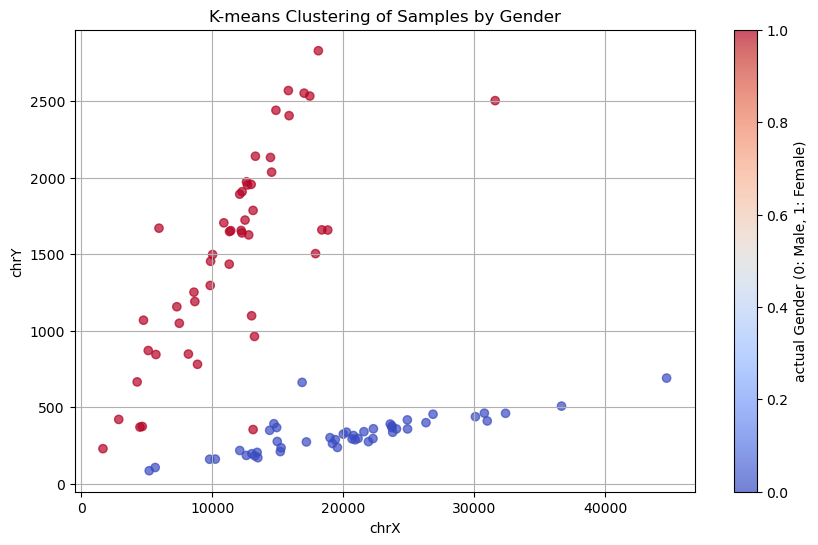

In [42]:
input_df = df_6.copy()

"""
Train a K-means clustering model on the provided DataFrame and plot the results.

Parameters:
    input_df (pd.DataFrame): The input DataFrame containing the data.

Returns:
    KMeans: The trained KMeans model.
"""

# Ensure the required columns are present in the DataFrame
required_columns = ['chrX', 'chrY', 'sry_count', 'chr_ratio']
if not all(col in input_df.columns for col in required_columns):
    raise ValueError(f"The input DataFrame must contain the following columns: {required_columns}")

# Select features for clustering
selected_features = input_df[required_columns]
samples = input_df["sample"]
# Standardize the feature values to have mean=0 and variance=1
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)

# Create KMeans model with 2 clusters for gender classification
kmeans_model = KMeans(n_clusters=2, random_state=42)

# Fit the model
input_df['predicted_gender'] = kmeans_model.fit_predict(scaled_features)

scaled_features = pd.DataFrame(scaled_features, columns=required_columns)
scaled_features["sample"] = samples.reset_index(drop=True)
scaled_features["actual_sample_type"] = input_df["gender"]
scaled_features["predicted_gender"] = input_df['predicted_gender']


plt.figure(figsize=(10, 6))
plt.scatter(input_df['chrX'], input_df['chrY'], 
            c=input_df['gender'], cmap='coolwarm', alpha=0.7)

plt.title("K-means Clustering of Samples by Gender")
plt.xlabel("chrX")
plt.ylabel("chrY")

# Label points with sample names
#     for i in range(len(input_df)):
#         plt.annotate(input_df['sample'][i], (input_df['chrX'][i], input_df['chrY'][i]), fontsize=8)

plt.colorbar(label='actual Gender (0: Male, 1: Female)')
plt.grid()
plt.show()



In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(scaled_features['chrX'], scaled_features['chrY'], 
            c=scaled_features['predicted_gender'], cmap='coolwarm', alpha=0.7)

plt.title("K-means Clustering of Samples by Gender")
plt.xlabel("chrX")
plt.ylabel("chrY")

# Label points with sample names
#     for i in range(len(input_df)):
#         plt.annotate(input_df['sample'][i], (input_df['chrX'][i], input_df['chrY'][i]), fontsize=8)

plt.colorbar(label='Predicted Gender (0: Male, 1: Female)')
plt.grid()
plt.show()

KeyError: 'predicted_gender'

<Figure size 1000x600 with 0 Axes>

## PCA Plot

In [324]:
merged_filterd_df = thermo_df.copy()
# [col for col in merged_filterd_df.columns if 'readcount' in col and not col.endswith(('chrY', 'chrX'))] 

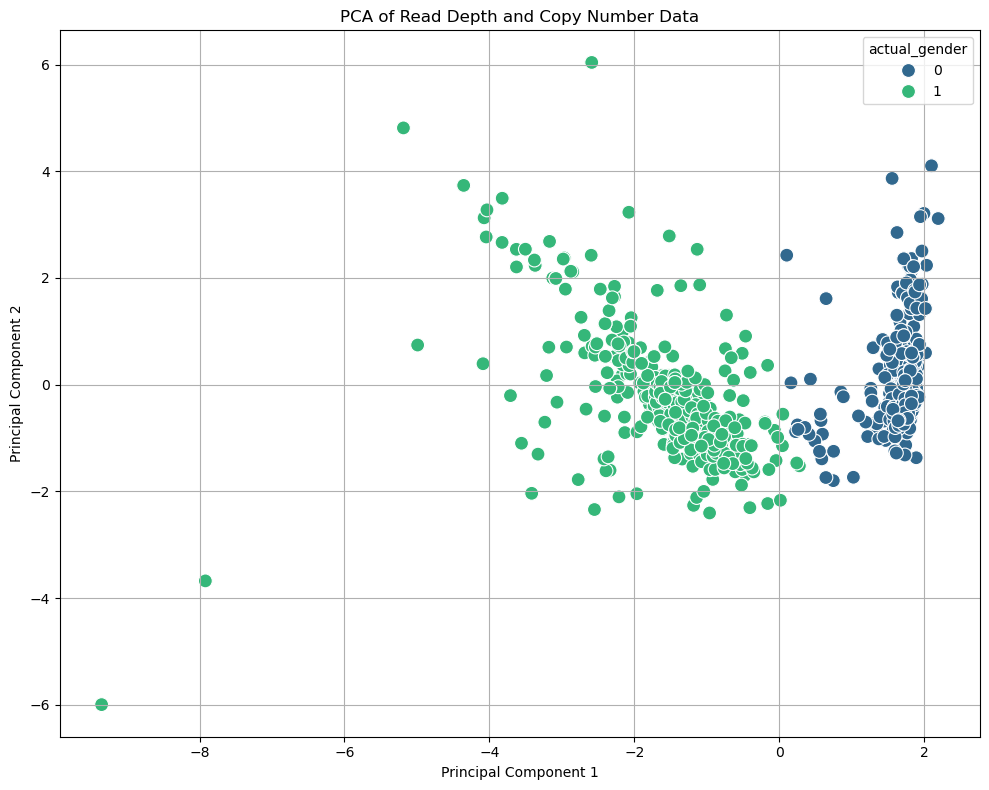

In [326]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler


# Step 1: Select the relevant columns for PCA (all read_depth and readcount columns)
# pca_columns = [col for col in merged_filterd_df.columns if 'readcount' in col or 'read_depth' in col]
# pca_columns = [col for col in merged_filterd_df.columns if 'readcount' in col]    # only for copy_Number
# pca_columns = [col for col in merged_filterd_df.columns if 'read_depth' in col]    # only for read_depth
pca_columns = ["chrX","chrY","sry_count","frac_X","frac_Y"]

# Drop 'sample' and 'sample_type' from the dataset for PCA analysis
pca_data = merged_filterd_df[pca_columns]

# # Step 2: Standardize the data (important for PCA)
scaler = StandardScaler()
pca_data_scaled = scaler.fit_transform(pca_data)
# pca_data_scaled = pca_data


# Add the 'gender' column back to the scaled data
# pca_data_scaled = pd.DataFrame(pca_data, columns=pca_columns)

# Now add the gender column
# pca_data_scaled['gender'] = merged_filterd_df['gender'].values

# Step 3: Perform PCA (reduce to 2 components)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(pca_data_scaled)

# Step 4: Create a DataFrame with the PCA components
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])

# Step 5: Add the 'sample' and 'sample_type' columns to the PCA DataFrame for visualization
pca_df['sample'] = merged_filterd_df['sample']
pca_df['actual_gender'] = merged_filterd_df['actual_gender']

# Step 6: Plot the PCA results with sample labels and hue by 'sample_type'
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='actual_gender', data=pca_df, palette='viridis', s=100, marker='o')

# # Add sample labels to the plot
# for i in range(pca_df.shape[0]):
#     plt.text(pca_df['PC1'][i], pca_df['PC2'][i], pca_df['sample'][i], fontsize=9, ha='right')

# Step 7: Customize the plot
plt.title('PCA of Read Depth and Copy Number Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='actual_gender')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

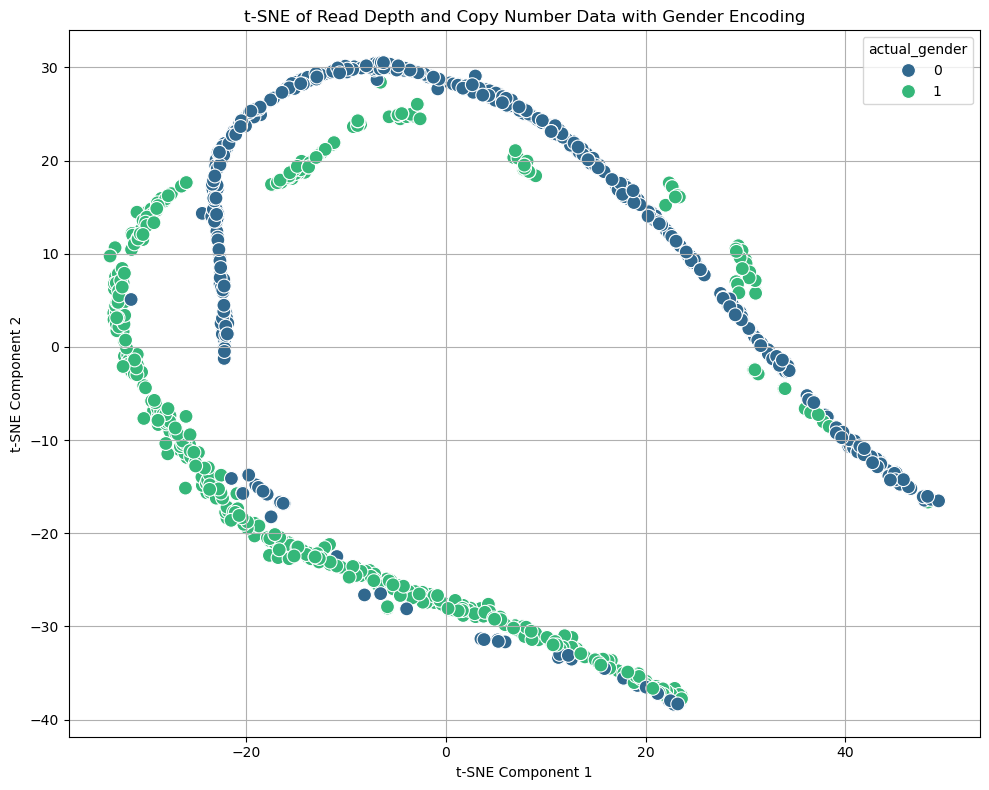

In [329]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder , RobustScaler
from sklearn.manifold import TSNE
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)


# Step 1: Select the relevant columns for t-SNE (all read_depth and readcount columns)
# tsne_columns = [col for col in merged_filterd_df.columns if 'readcount' in col or 'readcount' in col]
# tsne_columns = [col for col in merged_filterd_df.columns if 'read_depth' in col]    # only for copy_Number
# tsne_columns = [col for col in merged_filterd_df.columns if 'readcount' in col or 'read_depth' in col 
#                and not col.endswith(('chrY', 'chrX'))]
tsne_columns = ["chrX","chrY","sry_count" ,"frac_X","frac_Y"]
# 


# Step 2: Extract the data for t-SNE
tsne_data = merged_filterd_df[tsne_columns]

tsne_data = poly.fit_transform(tsne_data)


# # Step 3: Standardize the data (important for t-SNE as well)
scaler = RobustScaler()
tsne_data_scaled = scaler.fit_transform(tsne_data)

# # Add the 'gender' column back to the scaled data
tsne_data = pd.DataFrame(tsne_data)


# Step 5: Perform t-SNE (reduce to 2 components)
perplexity_value = min(30, tsne_data.shape[0] - 1)  # Ensure it's less than n_samples
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value , learning_rate=200)
tsne_components = tsne.fit_transform(tsne_data)

# Step 6: Create a DataFrame with the t-SNE components
tsne_df = pd.DataFrame(data=tsne_components, columns=['TSNE1', 'TSNE2'])

# Step 7: Add the 'sample', 'sample_type', and encoded 'gender' columns to the t-SNE DataFrame for visualization
tsne_df['sample'] = merged_filterd_df['sample']
tsne_df['actual_gender'] = merged_filterd_df['actual_gender']
# tsne_df['gender'] = merged_filterd_df['gender']

# Step 8: Plot the t-SNE results with sample labels and hue by 'sample_type'
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='actual_gender', data=tsne_df, palette='viridis', s=100, marker='o')

# Add sample labels to the plot
# for i in range(tsne_df.shape[0]):
#     plt.text(tsne_df['TSNE1'][i], tsne_df['TSNE2'][i], tsne_df['sample'][i], fontsize=9, ha='right')

# Step 9: Customize the plot
plt.title('t-SNE of Read Depth and Copy Number Data with Gender Encoding')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='actual_gender')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
input_df = thermo.copy()

"""
Train a K-means clustering model on the provided DataFrame and plot the results.

Parameters:
    input_df (pd.DataFrame): The input DataFrame containing the data.

Returns:
    KMeans: The trained KMeans model.
"""

# Ensure the required columns are present in the DataFrame
required_columns = ['sry_count', 'chr_ratio',"frac_X", "frac_Y"]
if not all(col in input_df.columns for col in required_columns):
    raise ValueError(f"The input DataFrame must contain the following columns: {required_columns}")

# Select features for clustering
selected_features = input_df[required_columns]
samples = input_df["sample"]

# Standardize the feature values to have mean=0 and variance=1
scaled_features = loaded_scaler.transform(selected_features)

# Fit the model
input_df['predicted_gender'] = loaded_model.fit_predict(scaled_features)
predictions = loaded_model.predict(scaled_features)


scaled_features = pd.DataFrame(scaled_features, columns=required_columns)
scaled_features["sample"] = samples.reset_index(drop=True)
scaled_features["actual_sample_type"] = input_df["gender"]
scaled_features["predicted_gender"] = input_df['predicted_gender']


plt.figure(figsize=(10, 6))
plt.scatter(input_df['frac_X'], input_df['frac_Y'], 
            c=input_df['predicted_gender'], cmap='coolwarm', alpha=0.7)

# Add sample labels to the plot
plt.text(input_df['frac_X'][15], input_df['frac_Y'][15], input_df['sample'][15], fontsize=9, ha='right')
plt.text(input_df['frac_X'][52], input_df['frac_Y'][52], input_df['sample'][52], fontsize=9, ha='right')

plt.title("K-means Clustering of Samples by Gender")
plt.xlabel("frac_X")
plt.ylabel("frac_Y")

# Label points with sample names
#     for i in range(len(input_df)):
#         plt.annotate(input_df['sample'][i], (input_df['chrX'][i], input_df['chrY'][i]), fontsize=8)

plt.colorbar(label='actual Gender (0: Male, 1: Female)')
plt.grid()
plt.show()

# input_df['predicted_gender'] = input_df['predicted_gender'].apply(lambda x: 1 if x == 0 else 0)


In [63]:

# Get a list of all TSV files in the directory
tsv_files = glob.glob(os.path.join(dir1, "*_cnv.tsv"))

# Define the columns of interest
columns_of_interest = ['chromosome', 'readcount', 'gender', 'start']

# Initialize an empty list to hold DataFrames
df_list = []

# Loop through each TSV file and read it
for file in tsv_files:
    df = pd.read_csv(file, sep="\t")
    df['sample'] = os.path.basename(file)

    # Append the cleaned DataFrame to the list
    df_list.append(df)

# Combine all DataFrames into one
combined_df = pd.concat(df_list, ignore_index=True)

# Filter for rows where 'chromosome' is either 'chrX' or 'chrY'
combined_df = combined_df[combined_df['chromosome'].isin(['chrX', 'chrY'])]

# Remove '_l1_cnv.tsv' from the sample column
combined_df['sample'] = combined_df['sample'].str.replace('_l1_cnv.tsv', '', regex=False)

# Group by chromosome and sample and aggregate
reduced_row = combined_df.groupby(['chromosome', 'gender', 'sample']).agg({
    'readcount': 'sum',  # Sum readcount values
}).reset_index()

# Pivot the DataFrame to get chromosomes as columns
pivoted_df = reduced_row.pivot_table(index=['gender', 'sample'], columns='chromosome', values='readcount')

# Reset the index to flatten the DataFrame
pivoted_df.reset_index(inplace=True)

# Filter for 'chrY' with specific start values for SRY gene
sry_df = combined_df[
    (combined_df['chromosome'] == 'chrY') & 
    (combined_df['start'].isin([2000001]))
][['readcount', 'sample']]

# SRY Gene Preprocessing
sry_df.rename(columns={'readcount': 'sry_count'}, inplace=True)
sry_df.reset_index(inplace=True, drop=True)

# Merge the pivoted DataFrame with the SRY data
final_df = pd.merge(pivoted_df, sry_df, on='sample', how='inner')

final_df['sample'] = final_df['sample'].str.replace('flexbarOut_barcode_', '', regex=False).str.replace('_trim_filtered_cnv.tsv', '', regex=False)

final_df['chr_ratio'] = final_df['chrX'] / final_df['chrY'].replace(0, np.nan) 
final_df.sort_values(by='chr_ratio',ascending=True,inplace=True)

# New Column  
final_df["frac_X"] = final_df["chrX"]/(final_df["chrX"] + final_df["chrY"] )
final_df["frac_Y"] = final_df["chrY"]/(final_df["chrX"] + final_df["chrY"] )


## Load and Process tsv files bulk

In [29]:
def load_and_process_tsv_files(directory):
    """
    Load and process TSV files from the specified directory.

    Parameters:
    directory (str): The path to the directory containing TSV files.

    Returns:
    pd.DataFrame: A DataFrame containing the processed data.
    """
    # Get a list of all TSV files in the directory
    tsv_files = glob.glob(os.path.join(directory, "*_cnv.tsv"))

    # Define the columns of interest
    columns_of_interest = ['chromosome', 'readcount', 'gender', 'start']
    
    # Initialize an empty list to hold DataFrames
    df_list = []

    # Loop through each TSV file and read it
    for file in tsv_files:
        df = pd.read_csv(file, sep="\t")

        # Keep only the columns of interest if they exist in the current file
        df = df[[col for col in columns_of_interest if col in df.columns]]
        
        # Add a column for the file name (optional, helps track which file the data came from)
        df['sample'] = os.path.basename(file)
        
        # Append the cleaned DataFrame to the list
        df_list.append(df)

    # Combine all DataFrames into one
    combined_df = pd.concat(df_list, ignore_index=True)

    # Filter for rows where 'chromosome' is either 'chrX' or 'chrY'
    combined_df = combined_df[combined_df['chromosome'].isin(['chrX', 'chrY'])]

    # Remove '_l1_cnv.tsv' from the sample column
    combined_df['sample'] = combined_df['sample'].str.replace('_l1_cnv.tsv', '', regex=False)

    # Group by chromosome and sample and aggregate
    reduced_row = combined_df.groupby(['chromosome', 'gender', 'sample']).agg({
        'readcount': 'sum',  # Sum readcount values
    }).reset_index()

    # Pivot the DataFrame to get chromosomes as columns
    pivoted_df = reduced_row.pivot_table(index=['gender', 'sample'], columns='chromosome', values='readcount')

    # Reset the index to flatten the DataFrame
    pivoted_df.reset_index(inplace=True)

    # Filter for 'chrY' with specific start values for SRY gene
    sry_df = combined_df[
        (combined_df['chromosome'] == 'chrY') & 
        (combined_df['start'].isin([2000001]))
    ][['readcount', 'sample']]

    # SRY Gene Preprocessing
    sry_df.rename(columns={'readcount': 'sry_count'}, inplace=True)
    sry_df.reset_index(inplace=True, drop=True)

    # Merge the pivoted DataFrame with the SRY data
    final_df = pd.merge(pivoted_df, sry_df, on='sample', how='inner')

    # Encode gender as 0 for Male, 1 for Female
    final_df['gender'] = final_df['gender'].map({'Male': 1, 'Female': 0})
    
    final_df['sample'] = final_df['sample'].str.replace('flexbarOut_barcode_', '', regex=False).str.replace('_trim_filtered_cnv.tsv', '', regex=False)
    
    final_df['chr_ratio'] = final_df['chrX'] / final_df['chrY'].replace(0, np.nan) 
    final_df.sort_values(by='chr_ratio',ascending=True,inplace=True)
    
    # New Column  
    final_df["frac_X"] = final_df["chrX"]/(final_df["chrX"] + final_df["chrY"] )
    final_df["frac_Y"] = final_df["chrY"]/(final_df["chrX"] + final_df["chrY"] )

    return final_df

## (K-Means Clustering)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def train_kmeans_model_and_plot(input_df: pd.DataFrame):
    """
    Train a K-means clustering model on the provided DataFrame and plot the results.

    Parameters:
        input_df (pd.DataFrame): The input DataFrame containing the data.

    Returns:
        KMeans: The trained KMeans model.
    """
    
    # Ensure the required columns are present in the DataFrame
    required_columns = ['chrX', 'chrY', 'sry_count', 'chr_ratio']
    if not all(col in input_df.columns for col in required_columns):
        raise ValueError(f"The input DataFrame must contain the following columns: {required_columns}")

    # Select features for clustering
    selected_features = input_df[required_columns]

    # Standardize the feature values to have mean=0 and variance=1
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(selected_features)

    # Create KMeans model with 2 clusters for gender classification
    kmeans_model = KMeans(n_clusters=2, random_state=42)

    # Fit the model
    input_df['predicted_gender'] = kmeans_model.fit_predict(scaled_features)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(input_df['chrX'], input_df['chrY'], 
                c=input_df['predicted_gender'], cmap='coolwarm', alpha=0.7)

    plt.title("K-means Clustering of Samples by Gender")
    plt.xlabel("chrX")
    plt.ylabel("chrY")
    
    # Label points with sample names
#     for i in range(len(input_df)):
#         plt.annotate(input_df['sample'][i], (input_df['chrX'][i], input_df['chrY'][i]), fontsize=8)

    plt.colorbar(label='Predicted Gender (0: Male, 1: Female)')
    plt.grid()
    plt.show()
    

    return kmeans_model,scaler 


import pickle

def save_combined_model(kmeans_model, scaler, combined_filename: str):
    """
    Save both the KMeans model and the StandardScaler to a single file.

    Parameters:
        kmeans_model (KMeans): The trained KMeans model.
        scaler (StandardScaler): The fitted StandardScaler.
        combined_filename (str): The filename to save both the model and the scaler.
    """

    # Create a dictionary to store both the model and scaler
    combined_model = {
        'model': kmeans_model,
        'scaler': scaler
    }

    # Save the dictionary to a single file
    with open(combined_filename, 'wb') as combined_file:
        pickle.dump(combined_model, combined_file)
    
    print(f"Combined model and scaler saved to {combined_filename}")


## Validation Kmeans with k-fold 

In [9]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score

def validate_kmeans_with_kfold_no_labels(input_df: pd.DataFrame, n_splits=5):
    """
    Perform K-Fold cross-validation to validate the KMeans clustering model and plot inertia per fold.

    Parameters:
        input_df (pd.DataFrame): The input DataFrame containing the data.
        n_splits (int): Number of splits for KFold cross-validation.

    Returns:
        float: The average inertia score across all folds.
    """
    
    # Ensure the required columns are present in the DataFrame
    required_columns = ['chrX', 'chrY', 'sry_count', 'chr_ratio']
    if not all(col in input_df.columns for col in required_columns):
        raise ValueError(f"The input DataFrame must contain the following columns: {required_columns}")
    
    # Select features for clustering
    selected_features = input_df[required_columns]  # Features to use for clustering
    
    # Standardize the feature values to have mean=0 and variance=1
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(selected_features)
    
    # Initialize KFold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    inertia_scores = []  # Stores the inertia scores for each fold
    silhouette_scores = []  # Stores silhouette scores for each fold
    
    # KFold loop
    for train_index, test_index in kf.split(scaled_features):
        X_train, X_test = scaled_features[train_index], scaled_features[test_index]
        
        # Train KMeans model with 2 clusters for gender classification
        kmeans_model = KMeans(n_clusters=2, random_state=42)
        kmeans_model.fit(X_train)
        
        # Calculate inertia (within-cluster sum of squares) for the test set
        inertia = kmeans_model.inertia_
        inertia_scores.append(inertia)
        
        # Calculate silhouette score for clustering
        silhouette_avg = silhouette_score(X_test, kmeans_model.predict(X_test))
        silhouette_scores.append(silhouette_avg)

    # Plot the inertia and silhouette scores for each fold
    plt.figure(figsize=(10, 6))
    
    plt.plot(range(1, n_splits+1), inertia_scores, marker='o', linestyle='--', color='b', label='Inertia per fold')
    plt.axhline(np.mean(inertia_scores), color='r', linestyle='-', label=f'Average Inertia: {np.mean(inertia_scores):.2f}')
    
    plt.plot(range(1, n_splits+1), silhouette_scores, marker='o', linestyle='--', color='g', label='Silhouette Score per fold')
    plt.axhline(np.mean(silhouette_scores), color='orange', linestyle='-', label=f'Avg Silhouette Score: {np.mean(silhouette_scores):.2f}')
    
    plt.title(f"K-Fold Cross-Validation (n_splits={n_splits}) - Inertia & Silhouette Score per Fold")
    plt.xlabel("Fold Number")
    plt.ylabel("Score")
    plt.xticks(range(1, n_splits+1))
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return the average inertia across all folds
    avg_inertia = np.mean(inertia_scores)
    avg_silhouette = np.mean(silhouette_scores)
    
    print(f"Average Inertia across {n_splits} folds: {avg_inertia:.2f}")
    print(f"Average Silhouette Score across {n_splits} folds: {avg_silhouette:.2f}")
    
    return avg_inertia, avg_silhouette


## PCA scatterplot and save

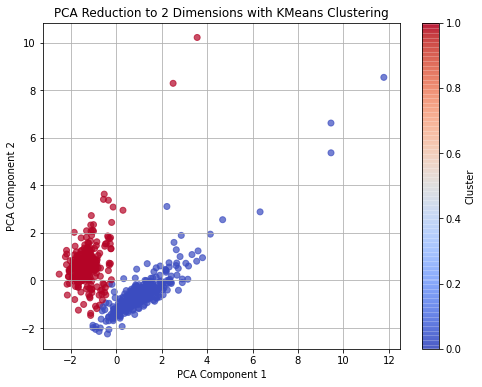

(KMeans(n_clusters=2, random_state=42), PCA(n_components=2))

In [61]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np


def pca_reduce_and_plot(input_df: pd.DataFrame, n_components=2, filename='pca_plot.png'):
    """
    Apply PCA to reduce the data to two dimensions and plot the clusters.
    
    Parameters:
        input_df (pd.DataFrame): The input DataFrame.
        n_components (int): Number of PCA components to retain.
    """
    
    required_columns = ['chrX', 'chrY', 'sry_count', 'chr_ratio']
    selected_features = input_df[required_columns]
    
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(selected_features)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_features)
    
    # Train KMeans on the reduced data
    kmeans_model = KMeans(n_clusters=2, random_state=42)
    predicted_clusters = kmeans_model.fit_predict(reduced_data)
    
    # Plot the reduced data
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=predicted_clusters, cmap='coolwarm', alpha=0.7)
    plt.title(f"PCA Reduction to {n_components} Dimensions with KMeans Clustering")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.colorbar(label='Cluster')
    plt.savefig(filename, dpi=500, bbox_inches='tight', format='png')

    plt.show()

    return kmeans_model, pca

pca_reduce_and_plot(thermo, n_components=2, filename="thermo_plot.png")

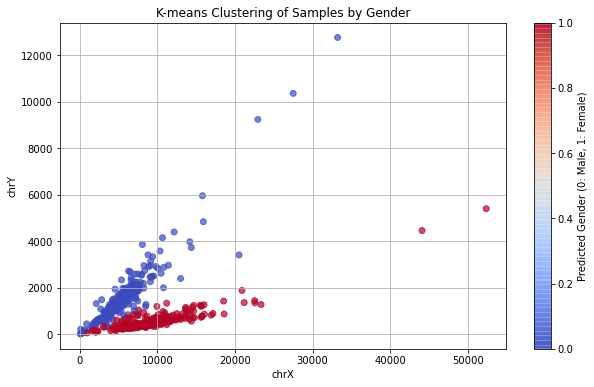

In [49]:
# k_model_df_1 = train_kmeans_model_and_plot(df_1)
# k_model_df_2 = train_kmeans_model_and_plot(df_2)
# k_model_df_3 = train_kmeans_model_and_plot(df_3)
# k_model_df_4 = train_kmeans_model_and_plot(df_4)
# k_model_df_5 = train_kmeans_model_and_plot(df_5)
kmeans_model, scaler = train_kmeans_model_and_plot(thermo)
# kmeans_model, scaler = train_kmeans_model_and_plot(nanopore)




# Step 1: Train the KMeans model and scaler with your DataFrame (e.g., thermo)
# kmeans_model_thermo, scaler_thermo = train_kmeans_model_and_plot(thermo)
# save_combined_model(kmeans_model_thermo, scaler_thermo, "kmeans_thermo_model")


# # # Step 2: Train the KMeans model and scaler with your DataFrame (e.g., nanopore)
# kmeans_model_nanopore, scaler_nanopore = train_kmeans_model_and_plot(nanopore)
# save_combined_model(kmeans_model_thermo, scaler_thermo, "kmeans_nanopore_model")


## Evaluate the results 

In [58]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate_classification(df, target_col='gender', pred_col='predicted_gender', sample_col='sample'):
    # True positives, true negatives, false positives, false negatives
    TP = len(df[(df[target_col] == 1) & (df[pred_col] == 1)])
    TN = len(df[(df[target_col] == 0) & (df[pred_col] == 0)])
    FP = len(df[(df[target_col] == 0) & (df[pred_col] == 1)])
    FN = len(df[(df[target_col] == 1) & (df[pred_col] == 0)])

    # Accuracy
    accuracy = (TP + TN) / len(df)

    # Sensitivity (Recall or True Positive Rate)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Specificity (True Negative Rate)
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    # Misclassified samples
    misclassified_samples = df[df[target_col] != df[pred_col]][sample_col].tolist()

    # Output results
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Sensitivity (Recall): {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print("Misclassified Samples:", misclassified_samples)


def evaluate_gender_predictions(input_df: pd.DataFrame) -> None:
    """
    Evaluate gender predictions using accuracy and confusion matrix.

    Parameters:
        input_df (pd.DataFrame): The DataFrame containing true and predicted gender columns.

    Returns:
        None: Prints accuracy and displays the confusion matrix.
    """
    # Print unique values for debugging
    print("Unique values in 'gender':", input_df['gender'].unique())
    print("Unique values in 'predicted_gender':", input_df['predicted_gender'].unique())

    # Calculate accuracy
    accuracy = accuracy_score(input_df['gender'], input_df['predicted_gender'])
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(input_df['gender'], input_df['predicted_gender'], labels=[0, 1])
    print("Confusion Matrix:")
    print(conf_matrix)

    # Optional: Visualize the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title('Confusion Matrix: Gender vs Predicted Gender')
    plt.xlabel('Predicted Gender')
    plt.ylabel('True Gender')
    plt.show()

# Example usage
# evaluate_gender_predictions(df_5)

##  Deployment On sinngle tsv

In [45]:
import pandas as pd
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import sys


def load_and_process_single_tsv(tsv_file: str) -> pd.DataFrame:

    # Define the columns of interest
    columns_of_interest = ['chromosome', 'readcount', 'start']

    # Read the single TSV file
    df = pd.read_csv(tsv_file, sep="\t")
#   df = pd.read_csv(tsv_file)

    # Keep only the columns of interest if they exist in the file
    df = df[[col for col in columns_of_interest if col in df.columns]]

    # # Add a column for the sample name (optional, helps track which file the data came from)
    # df['sample'] = os.path.basename(tsv_file)
    df['sample'] = "Sample"

    # Filter for rows where 'chromosome' is either 'chrX' or 'chrY'
    df = df[df['chromosome'].isin(['chrX', 'chrY'])]

    # Remove '_l1_cnv.tsv' from the sample column
    df['sample'] = df['sample'].str.replace('_l1_cnv.tsv', '', regex=False)

    # Group by chromosome and sample and aggregate
    reduced_row = df.groupby(['chromosome', 'sample']).agg({
        'readcount': 'sum',  # Sum readcount values
    }).reset_index()

    # Pivot the DataFrame to get chromosomes as columns
    pivoted_df = reduced_row.pivot_table(index=[ 'sample'], columns='chromosome', values='readcount')

    # Reset the index to flatten the DataFrame
    pivoted_df.reset_index(inplace=True)

    # Filter for 'chrY' with specific start values for the SRY gene
    sry_df = df[
        (df['chromosome'] == 'chrY') & 
        (df['start'].isin([2000001]))
    ][['readcount', 'sample']]

    # SRY Gene Preprocessing
    sry_df.rename(columns={'readcount': 'sry_count'}, inplace=True)
    sry_df.reset_index(inplace=True, drop=True)

    # Merge the pivoted DataFrame with the SRY data
    final_df = pd.merge(pivoted_df, sry_df, on='sample', how='inner')

    # Additional processing on the 'sample' column
    final_df['sample'] = final_df['sample'].str.replace('flexbarOut_barcode_', '', regex=False).str.replace('_trim_filtered_cnv.tsv', '', regex=False)
    
    # Calculate chromosome ratio
    final_df['chr_ratio'] = final_df['chrX'] / final_df['chrY'].replace(0, np.nan) 
    final_df.sort_values(by='chr_ratio', ascending=True, inplace=True)

    return final_df


def predict_gender(input_file: str, combined_model_path: str) -> pd.DataFrame:
    
    input_df = load_and_process_single_tsv(input_file)
    # Load the KMeans model    
    
    # Load the combined KMeans model and StandardScaler from one file
    with open(combined_model_path, 'rb') as file:
        loaded_data = pickle.load(file)
    
    # Extract the KMeans model and scaler from the loaded data
    loaded_model = loaded_data['model']
    loaded_scaler = loaded_data['scaler']
    
    # Ensure the DataFrame contains the required columns
    required_columns = ['chrX', 'chrY', 'sry_count', 'chr_ratio']
    if not all(col in input_df.columns for col in required_columns):
        raise ValueError(f"The input DataFrame must contain the following columns: {required_columns}")
    
    # Standardize the feature values using the loaded scaler
    scaled_features = loaded_scaler.transform(input_df[required_columns])

    # Predict using the loaded KMeans model
    predictions = loaded_model.predict(scaled_features)

    # Add predictions to the new DataFrame
    input_df['predicted_gender'] = predictions
    
    gender = input_df['predicted_gender'].astype(int)
    
    male = gender[gender==1]
    female = gender[gender==0]

    if not male.empty :
        return "Male"
    if not female.empty :
        return "Female" 


# if __name__ == "__main__":
#     predict_gender(sys.argv[1],"kmeans_model_thermo")






## Load model function


In [180]:

# Load the KMeans model    

# Load the combined KMeans model and StandardScaler from one file
with open("thermo_v2", 'rb') as file:
    loaded_data = pickle.load(file)

# Extract the KMeans model and scaler from the loaded data
loaded_model = loaded_data['model']
loaded_scaler = loaded_data['scaler']



## scatter plot plotting

In [334]:
import matplotlib.pyplot as plt

def plot_scatter_thermo(df, x_limits=None, y_limits=None):
    """
    Plots a scatterplot of frac_X vs frac_Y, colored by gender.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing frac_X, frac_Y, and gender columns.
    """
    plt.figure(figsize=(8, 6))
    
    # Create a scatter plot, coloring by gender
    scatter = plt.scatter(df['chrX'], df['chrY'], 
                          c=df['actual_gender'], cmap='coolwarm', alpha=0.7)
    
        # Set axis limits if provided
    if x_limits:
        plt.xlim(x_limits)
    if y_limits:
        plt.ylim(y_limits)

    plt.title('Scatterplot of frac_X vs frac_Y by Gender')
    plt.xlabel('chrX')
    plt.ylabel('chrY')
    
    # Add a color bar to indicate gender (0 = Male, 1 = Female)
    plt.colorbar(scatter, label='Gender (0 = Female, 1 = Male)')
    
    plt.grid(True)
    plt.show()

# # Example usage
# plot_scatter_thermo(thermo, x_limits=(0, 20000), y_limits=(0, 5000))

## Feature Selection 

Selected features: ['chrX', 'chrY', 'chr_ratio', 'frac_X']
Selected features: ['chr_ratio', 'frac_X']


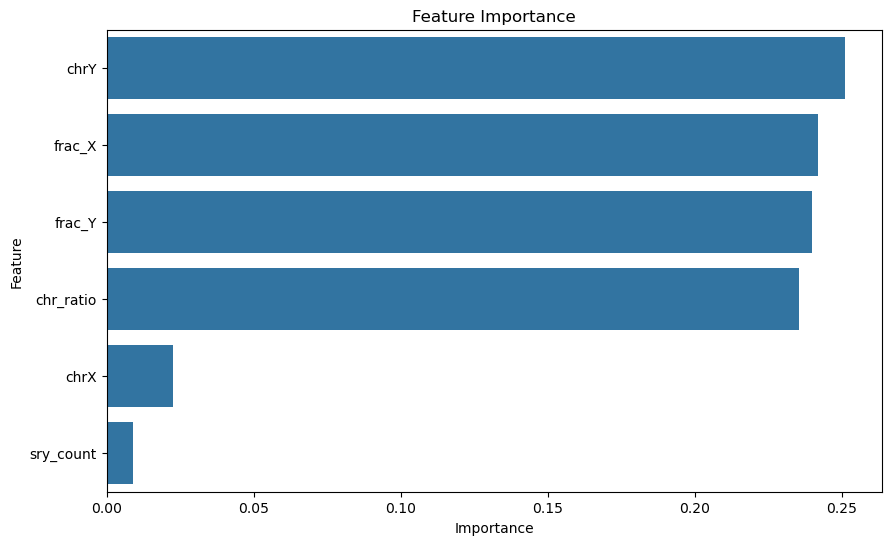

In [106]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

def feature_selection(df, target_column, num_features):
    """
    Perform feature selection using Recursive Feature Elimination (RFE).
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing features and target.
    target_column (str): The name of the target column (e.g., 'gender').
    num_features (int): The number of top features to select.

    Returns:
    list: The names of the selected features.
    """
    
    df = df.drop(columns=['sample'])
    
    # Separate features and target
    X = df.drop(columns=[target_column])  # Features
    y = df[target_column]  # Target (gender)
    
    # Initialize a Logistic Regression model
    model = LogisticRegression(max_iter=1000)
    
    # Initialize Recursive Feature Elimination (RFE)
    rfe = RFE(model, n_features_to_select=num_features)
    
    # Fit the model
    rfe = rfe.fit(X, y)
    
    # Get the selected feature names
    selected_features = X.columns[rfe.support_].tolist()
    
    print(f"Selected features: {selected_features}")
    
    return selected_features

# Example usage with the 'thermo' DataFrame, selecting the top 2 features
selected_features = feature_selection(thermo, target_column='gender', num_features=4)

from sklearn.ensemble import RandomForestClassifier

def feature_importance_selection(df, target_column, num_features):
    df = df.drop(columns=['sample'])
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Initialize a Random Forest model
    model = RandomForestClassifier(random_state=42)
    
    # Fit the model
    model.fit(X, y)
    
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame to hold feature names and their importance
    feature_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    })
    
    # Sort features by importance and select top 'num_features'
    top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(num_features)
    
    print(f"Selected features: {top_features['feature'].tolist()}")
    
    return top_features['feature'].tolist()

# Example usage with the 'thermo' DataFrame
selected_features_rf = feature_importance_selection(thermo, target_column='gender', num_features=2)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

def plot_feature_importance(df, target_column):
    """
    Plots the feature importance using RandomForestClassifier.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing features and target.
    target_column (str): The name of the target column (e.g., 'gender').
    """
    
    df = df.drop(columns=['sample'])

    # Separate features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Initialize a RandomForest model
    model = RandomForestClassifier(random_state=42)
    
    # Fit the model
    model.fit(X, y)
    
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Feature Importance')
    plt.show()

# Example usage with the 'thermo' DataFrame
plot_feature_importance(nanopore, target_column='gender')


## Single file load and process

In [113]:
import pandas as pd
import os
import numpy as np
import pandas as pd
import pickle
#from sklearn.preprocessing import StandardScaler
import sys


def load_and_process_single_tsv(tsv_file) -> pd.DataFrame:
    """
    Load and process a single TSV file.

    Parameters:
    tsv_file (str): The path to the single TSV file.

    Returns:
    pd.DataFrame: A DataFrame containing the processed data.
    """
    # Define the columns of interest
    columns_of_interest = ['chromosome', 'readcount', 'start']

    # Read the single TSV file
    # dtf = pd.read_csv(tsv_file, sep="\t")
    dtf = tsv_file

    # Keep only the columns of interest if they exist in the file
    dtf = dtf[[col for col in columns_of_interest if col in dtf.columns]]

    # # Add a column for the sample name (optional, helps track which file the data came from)
    # df['sample'] = os.path.basename(tsv_file)
    dtf['sample'] = "Sample"

    # Filter for rows where 'chromosome' is either 'chrX' or 'chrY'
    dtf = dtf[dtf['chromosome'].isin(['chrX', 'chrY'])]

    # Remove '_l1_cnv.tsv' from the sample column
    dtf['sample'] = dtf['sample'].str.replace('_l1_cnv.tsv', '', regex=False)

    # Group by chromosome and sample and aggregate
    reduced_row = dtf.groupby(['chromosome', 'sample']).agg({
        'readcount': 'sum',  # Sum readcount values
    }).reset_index()

    # Pivot the DataFrame to get chromosomes as columns
    pivoted_df = reduced_row.pivot_table(index=[ 'sample'], columns='chromosome', values='readcount')

    # Reset the index to flatten the DataFrame
    pivoted_df.reset_index(inplace=True)

    # Filter for 'chrY' with specific start values for the SRY gene
    sry_df = dtf[
        (dtf['chromosome'] == 'chrY') & 
        (dtf['start'].isin([2000001]))
    ][['readcount', 'sample']]

    # SRY Gene Preprocessing
    sry_df.rename(columns={'readcount': 'sry_count'}, inplace=True)
    sry_df.reset_index(inplace=True, drop=True)

    # Merge the pivoted DataFrame with the SRY data
    final_df = pd.merge(pivoted_df, sry_df, on='sample', how='inner')

    # Additional processing on the 'sample' column
    final_df['sample'] = final_df['sample'].str.replace('flexbarOut_barcode_', '', regex=False).str.replace('_trim_filtered_cnv.tsv', '', regex=False)
    
    # Calculate chromosome ratio
    final_df['chr_ratio'] = final_df['chrX'] / final_df['chrY'].replace(0, np.nan) 
    final_df.sort_values(by='chr_ratio', ascending=True, inplace=True)

    return final_df


def predict_gender(input_df: pd.DataFrame, combined_model_path: str) -> pd.DataFrame:
    
    input_df = load_and_process_single_tsv(input_df)
    # Load the KMeans model    
    
    # Load the combined KMeans model and StandardScaler from one file
    with open(combined_model_path, 'rb') as file:
        loaded_data = pickle.load(file)
    
    # Extract the KMeans model and scaler from the loaded data
    loaded_model = loaded_data['model']
    loaded_scaler = loaded_data['scaler']
    
    # Ensure the DataFrame contains the required columns
    required_columns = ['chrX', 'chrY', 'sry_count', 'chr_ratio']
    if not all(col in input_df.columns for col in required_columns):
        raise ValueError(f"The input DataFrame must contain the following columns: {required_columns}")
    
    # Standardize the feature values using the loaded scaler
    scaled_features = loaded_scaler.transform(input_df[required_columns])

    # Predict using the loaded KMeans model
    predictions = loaded_model.predict(scaled_features)

    # Add predictions to the new DataFrame
    input_df['predicted_gender'] = predictions
    
    gender = input_df['predicted_gender'].astype(int)
    
    male = gender[gender==1]
    female = gender[gender==0]

    if not male.empty :
        return "Male"
    if not female.empty :
        return "Female" 
